# Training Word Embeddings with gensim Word2Vec

---

__Elliott Forney - 2020__

In [81]:
import re, pickle

import gensim, nltk
import numpy as np

import regenerator

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/idfah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
data_stream = regenerator.Stream.from_txt('wikipedia.txt')
data_stream = data_stream.map(lambda line: line.strip('\r\n')).filter(lambda item: item)
data_stream

<Stream>:
'Anarchism',
"Anarchism is an anti-authoritarian political and social philosophy that rejects hierarchy as unjust and advocates its replacement with self-managed, self-governed societies based on voluntary, cooperative institutions. These institutions are often described as stateless societies, although several authors have defined them more specifically as distinct institutions based on non-hierarchical or free associations. Anarchism's central disagreement with other ideologies is that it holds the state to be undesirable, unnecessary, and harmful.",
'Anarchism is usually placed on the far-left of the political spectrum, and much of its economics and legal philosophy reflect anti-authoritarian interpretations of communism, collectivism, syndicalism, mutualism, or participatory economics. As anarchism does not offer a fixed body of doctrine from a single particular worldview, many anarchist types and traditions exist and varieties of anarchy diverge widely. Anarchist schools

In [4]:
class Tokenizer:                                                                                    
    def __init__(self, language='english'):
        self.language = language
        
        #self.nltk_word_tokenizer = nltk.tokenize.WordPunctTokenizer()
        self.nltk_word_tokenizer = nltk.tokenize.TreebankWordTokenizer()
        self.nltk_sent_tokenizer = nltk.data.load(
            'tokenizers/punkt/{}.pickle'.format(language))
                                                                                                    
    def __call__(self, text):
        return [self.nltk_word_tokenizer.tokenize(sent)
                for sent in self.nltk_sent_tokenizer.tokenize(text)]

In [5]:
tokenizer = Tokenizer()

In [6]:
token_stream = data_stream.map(tokenizer).unchunk()
token_stream

<Stream>:
['Anarchism'],
['Anarchism', 'is', 'an', 'anti-authoritarian', 'political', 'and', 'social', 'philosophy', 'that', 'rejects', 'hierarchy', 'as', 'unjust', 'and', 'advocates', 'its', 'replacement', 'with', 'self-managed', ',', 'self-governed', 'societies', 'based', 'on', 'voluntary', ',', 'cooperative', 'institutions', '.'],
['These', 'institutions', 'are', 'often', 'described', 'as', 'stateless', 'societies', ',', 'although', 'several', 'authors', 'have', 'defined', 'them', 'more', 'specifically', 'as', 'distinct', 'institutions', 'based', 'on', 'non-hierarchical', 'or', 'free', 'associations', '.'],
['Anarchism', "'s", 'central', 'disagreement', 'with', 'other', 'ideologies', 'is', 'that', 'it', 'holds', 'the', 'state', 'to', 'be', 'undesirable', ',', 'unnecessary', ',', 'and', 'harmful', '.'],
['Anarchism', 'is', 'usually', 'placed', 'on', 'the', 'far-left', 'of', 'the', 'political', 'spectrum', ',', 'and', 'much', 'of', 'its', 'economics', 'and', 'legal', 'philosophy', 're

In [7]:
lower_token_stream = token_stream.map(lambda line: list(map(str.lower, line)))
lower_token_stream

<Stream>:
['anarchism'],
['anarchism', 'is', 'an', 'anti-authoritarian', 'political', 'and', 'social', 'philosophy', 'that', 'rejects', 'hierarchy', 'as', 'unjust', 'and', 'advocates', 'its', 'replacement', 'with', 'self-managed', ',', 'self-governed', 'societies', 'based', 'on', 'voluntary', ',', 'cooperative', 'institutions', '.'],
['these', 'institutions', 'are', 'often', 'described', 'as', 'stateless', 'societies', ',', 'although', 'several', 'authors', 'have', 'defined', 'them', 'more', 'specifically', 'as', 'distinct', 'institutions', 'based', 'on', 'non-hierarchical', 'or', 'free', 'associations', '.'],
['anarchism', "'s", 'central', 'disagreement', 'with', 'other', 'ideologies', 'is', 'that', 'it', 'holds', 'the', 'state', 'to', 'be', 'undesirable', ',', 'unnecessary', ',', 'and', 'harmful', '.'],
['anarchism', 'is', 'usually', 'placed', 'on', 'the', 'far-left', 'of', 'the', 'political', 'spectrum', ',', 'and', 'much', 'of', 'its', 'economics', 'and', 'legal', 'philosophy', 're

In [8]:
vocab_size = 200_000
embed_dim = 128

In [9]:
counts = collections.Counter(lower_token_stream.unchunk())
len(counts)

10750349

In [10]:
most_common_words = counts.most_common(vocab_size)
most_common_words[:10]

[('the', 158699663),
 (',', 127369085),
 ('.', 101273935),
 ('of', 74562235),
 ('in', 64649497),
 ('and', 64029313),
 ('a', 46418627),
 ('to', 45257309),
 ('was', 27921609),
 ("''", 25546798)]

In [11]:
del counts

In [12]:
min_count = most_common_words[-1][1]
min_count

153

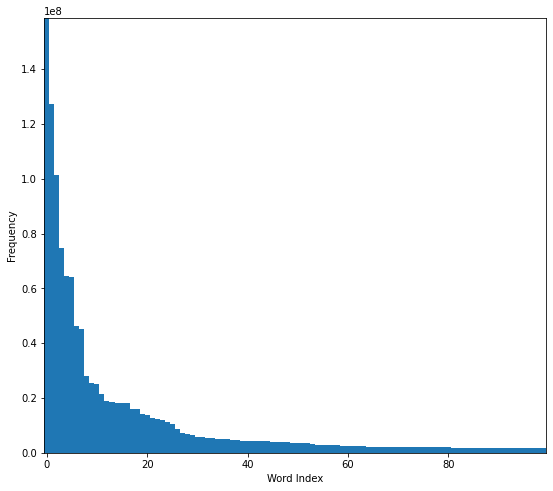

In [68]:
words, counts = zip(*most_common_words[:100])

plt.bar(range(len(counts)), counts, width=1.0);
plt.autoscale(tight=True);
plt.xlabel('Word Index');
plt.ylabel('Frequency');

In [14]:
vocab = set(word for word, count in most_common_words)
list(vocab)[:10]

['agre',
 'nadeem',
 "o'keefe",
 '1259',
 'autoregressive',
 'valeryevich',
 'kwe',
 'impious',
 'malabar',
 'pınar']

In [15]:
num_regex = re.compile(r'^[\−\-\+]?[\$¢€£¥₹₤]?\.?\d+([\.,:/]\d+)*$')

def replace_word(word):
    #if word.isdigit():
    if num_regex.match(word):
        return '<num>'
    
    if not word in vocab:
        return '<unk>'
    
    return word

sub_lower_token_stream = lower_token_stream.map(lambda sent: list(map(replace_word, sent)))
sub_lower_token_stream

<Stream>:
['anarchism'],
['anarchism', 'is', 'an', 'anti-authoritarian', 'political', 'and', 'social', 'philosophy', 'that', 'rejects', 'hierarchy', 'as', 'unjust', 'and', 'advocates', 'its', 'replacement', 'with', 'self-managed', ',', 'self-governed', 'societies', 'based', 'on', 'voluntary', ',', 'cooperative', 'institutions', '.'],
['these', 'institutions', 'are', 'often', 'described', 'as', 'stateless', 'societies', ',', 'although', 'several', 'authors', 'have', 'defined', 'them', 'more', 'specifically', 'as', 'distinct', 'institutions', 'based', 'on', 'non-hierarchical', 'or', 'free', 'associations', '.'],
['anarchism', "'s", 'central', 'disagreement', 'with', 'other', 'ideologies', 'is', 'that', 'it', 'holds', 'the', 'state', 'to', 'be', 'undesirable', ',', 'unnecessary', ',', 'and', 'harmful', '.'],
['anarchism', 'is', 'usually', 'placed', 'on', 'the', 'far-left', 'of', 'the', 'political', 'spectrum', ',', 'and', 'much', 'of', 'its', 'economics', 'and', 'legal', 'philosophy', 're

In [16]:
with open('tokenized.txt', mode='w', encoding='utf8') as fh:
    for i, sent in enumerate(sub_lower_token_stream):
        fh.write(' '.join(sent) + '\n')

In [17]:
sent_stream = regenerator.Stream.from_txt('tokenized.txt').map(str.split)
sent_stream

<Stream>:
['anarchism'],
['anarchism', 'is', 'an', 'anti-authoritarian', 'political', 'and', 'social', 'philosophy', 'that', 'rejects', 'hierarchy', 'as', 'unjust', 'and', 'advocates', 'its', 'replacement', 'with', 'self-managed', ',', 'self-governed', 'societies', 'based', 'on', 'voluntary', ',', 'cooperative', 'institutions', '.'],
['these', 'institutions', 'are', 'often', 'described', 'as', 'stateless', 'societies', ',', 'although', 'several', 'authors', 'have', 'defined', 'them', 'more', 'specifically', 'as', 'distinct', 'institutions', 'based', 'on', 'non-hierarchical', 'or', 'free', 'associations', '.'],
['anarchism', "'s", 'central', 'disagreement', 'with', 'other', 'ideologies', 'is', 'that', 'it', 'holds', 'the', 'state', 'to', 'be', 'undesirable', ',', 'unnecessary', ',', 'and', 'harmful', '.'],
['anarchism', 'is', 'usually', 'placed', 'on', 'the', 'far-left', 'of', 'the', 'political', 'spectrum', ',', 'and', 'much', 'of', 'its', 'economics', 'and', 'legal', 'philosophy', 're

In [18]:
model = gensim.models.Word2Vec(                                                                 
    sent_stream,
    size=embed_dim,
    window=5,
    min_count=min_count,
    workers=20,
    iter=20)

In [19]:
model.wv.most_similar('luke')

[('matthew', 0.8369596004486084),
 ('dominic', 0.7954682111740112),
 ('aidan', 0.7744234204292297),
 ('damian', 0.7680534720420837),
 ('patrick', 0.7464171648025513),
 ('michael', 0.7377211451530457),
 ('brendan', 0.736193060874939),
 ('caleb', 0.7347820401191711),
 ('peter', 0.7310853600502014),
 ('anthony', 0.7236428260803223)]

In [20]:
test_words = ['space', 'trump', 'obama', 'apollo', 'mars', 'the', 'is', 'and', 'cat', 'dog', 'elliott', ',',   
              'maggie', '.', '99', 'bksdhjfbhyjk', 'america', 'canada', 'colorado', 'omega', 'pytorch',
              'ubiquitous', 'deleterious', 'isomorphism', 'aberrant', 'awesomesauce', 'lol', 'yeah', 'nah']

for word in test_words:
    word = replace_word(word)
        
    similar, _scores = zip(*model.wv.most_similar(word))
    print(word, end=': ')
    print(similar)
    print()

space: ('spaces', 'workspace', 'module', 'projection', 'iss', 'microgravity', '3-dimensional', 'shuttle', 'hangar', 'storage')

trump: ('obama', 'trump’s', 'reagan', 'putin', 'nixon', 'biden', 'clinton', 'ahmadinejad', 'rumsfeld', 'duterte')

obama: ('trump', 'reagan', 'clinton', 'barack', 'nixon', 'obama’s', 'ahmadinejad', 'mccain', 'biden', 'putin')

apollo: ('gemini', 'artemis', 'orion', 'helios', 'athena', 'jupiter', 'neptune', 'hermes', 'astronauts', 'skylab')

mars: ('martian', 'phobos', 'venus', 'pluto', 'earth', 'enceladus', 'venusian', 'lander', 'planet', 'uranus')

the: ('its', 'this', "'s", 'their', 'a', 'another', 'an', '.the', 'our', 'whose')

is: ('was', 'exists', 'are', 'becomes', 'remains', 'represents', 'stands', 'contains', 'occurs', 'became')

and: ('while', '.', 'which', 'who', 'whose', 'whilst', 'and/or', 'where', 'including', 'whereas')

cat: ('dog', 'rabbit', 'monkey', 'rat', 'pug', 'pig', 'duck', 'puppy', 'kitten', 'mouse')

dog: ('cat', 'rabbit', 'puppy', 'dogs

In [21]:
model.wv.index2word[:10], len(model.wv.index2word)

(['the', ',', '.', 'of', '<num>', 'in', 'and', '<unk>', 'a', 'to'], 193678)

In [22]:
model.wv.vectors, model.wv.vectors.shape

(array([[-0.8575, -2.7653, -2.6305, -1.574 , ..., -3.6408,  1.2637,
          2.2043,  4.6609],
        [-1.0798, -0.7027,  1.5528,  0.7442, ...,  2.2586,  0.8912,
         -0.1333,  1.1425],
        [-2.9457, -2.7986, -2.019 , -3.0694, ...,  2.3304, -3.8821,
         -1.1343,  3.5724],
        [ 0.1944, -0.3305,  1.5819, -3.148 , ...,  4.4609,  2.3739,
          1.1674,  1.1565],
        ...,
        [ 0.1967,  1.3848, -0.0395, -1.6198, ...,  0.8508,  0.2021,
          0.1517, -0.6075],
        [ 0.0243,  1.2195,  0.3135, -0.1208, ...,  1.5937,  1.6113,
         -0.2293, -0.5243],
        [-0.4713, -0.5075,  1.7965,  0.7905, ..., -0.0667,  0.0523,
         -2.6759,  1.5628],
        [-0.4909,  1.6613, -1.481 , -1.9298, ...,  0.0203, -0.6123,
          0.6429, -0.8831]], dtype=float32),
 (193678, 128))

In [23]:
filename = f'wikipedia-cbow-{embed_dim}d-{vocab_size // 1000}k.txt'

with open(filename, mode='w', encoding='utf8') as fh:
    for word, vector in zip(model.wv.index2word, model.wv.vectors):
        str_vector = ' '.join(str(round(val, 12)) for val in vector)
        fh.write(f'{word} {str_vector}\n')

In [27]:
emb_mat = model.wv.vectors
emb_mat.shape

(193678, 128)

In [60]:
idx2word = model.wv.index2word
len(idx2word)

193678

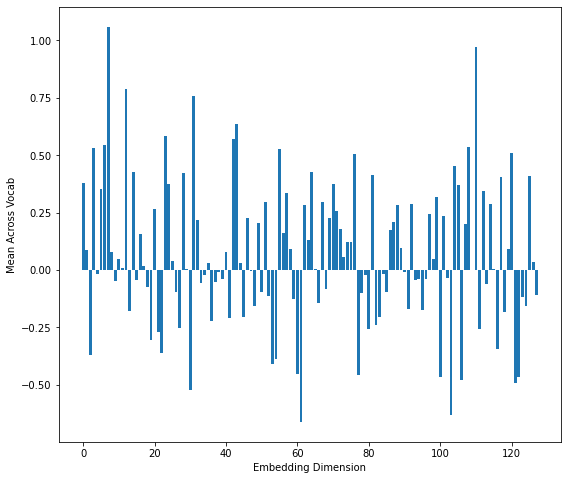

In [69]:
plt.bar(range(embed_dim), emb_mat.mean(axis=0));
plt.xlabel('Embedding Dimension');
plt.ylabel('Mean Across Vocab');

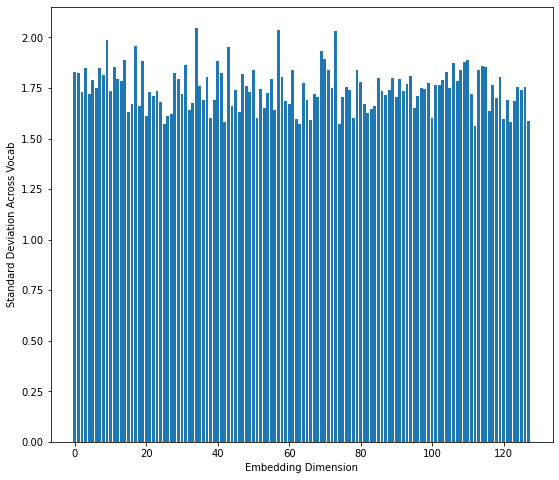

In [70]:
plt.bar(range(embed_dim), emb_mat.std(axis=0));
plt.xlabel('Embedding Dimension');
plt.ylabel('Standard Deviation Across Vocab');

In [71]:
l2 = np.sqrt((emb_mat**2).sum(1))
l2.shape

(193678,)

In [72]:
l2.min(), l2.max(), l2.mean()

(0.5268267, 74.75531, 19.161089)

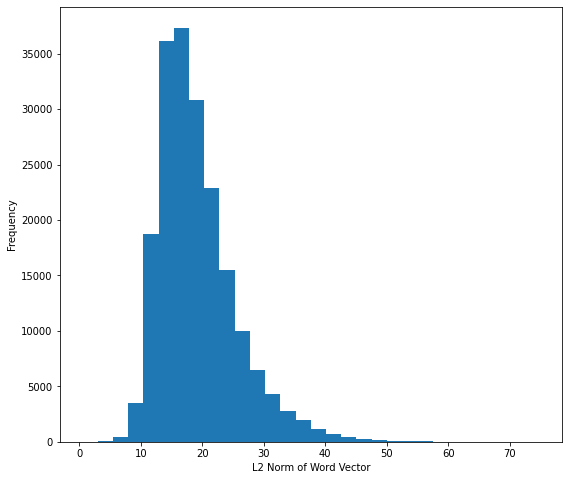

In [73]:
plt.hist(l2, bins=30);
plt.xlabel('L2 Norm of Word Vector');
plt.ylabel('Frequency');

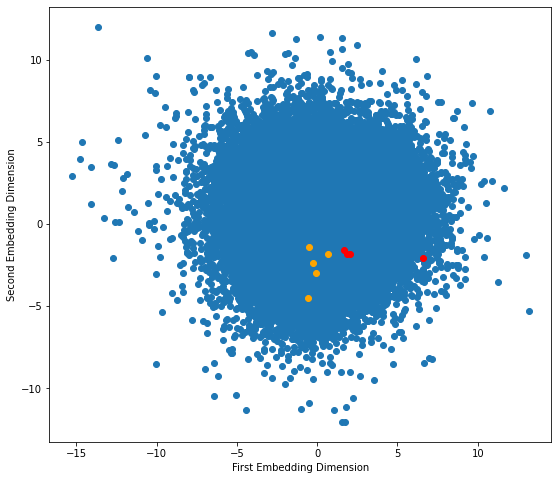

In [74]:
plt.scatter(emb_mat[:, 0], emb_mat[:, 1]);
plt.xlabel('First Embedding Dimension');
plt.ylabel('Second Embedding Dimension');

words = ('elliott', 'fred', 'frank', 'john')
idxs = [idx2word.index(word) for word in words]
plt.scatter(emb_mat[idxs, 0], emb_mat[idxs, 1], color='red');

words = ('omega', 'mu', 'alpha', 'beta', 'gamma')
idxs = [idx2word.index(word) for word in words]
plt.scatter(emb_mat[idxs, 0], emb_mat[idxs, 1], color='orange');

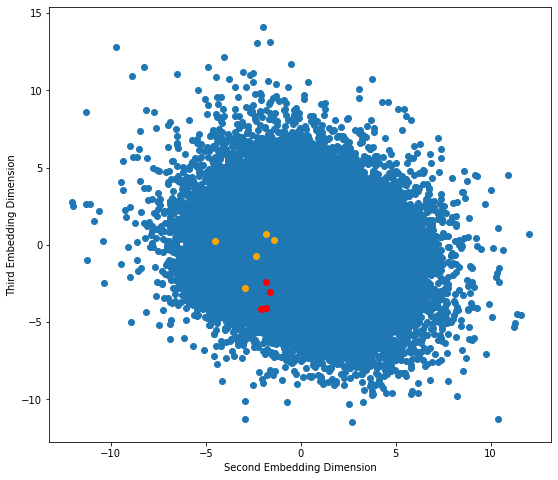

In [75]:
plt.scatter(emb_mat[:, 1], emb_mat[:, 2]);
plt.xlabel('Second Embedding Dimension');
plt.ylabel('Third Embedding Dimension');

words = ('elliott', 'fred', 'frank', 'john')
idxs = [idx2word.index(word) for word in words]
plt.scatter(emb_mat[idxs, 1], emb_mat[idxs, 2], color='red');

words = ('omega', 'mu', 'alpha', 'beta', 'gamma')
idxs = [idx2word.index(word) for word in words]
plt.scatter(emb_mat[idxs, 1], emb_mat[idxs, 2], color='orange');

In [76]:
means = emb_mat.mean(0)
u, d, v = np.linalg.svd(emb_mat - means, full_matrices=False)

mags = d**2 / (emb_mat.shape[0] - 1.0)
w = v.T / d

pcomps = emb_mat @ w

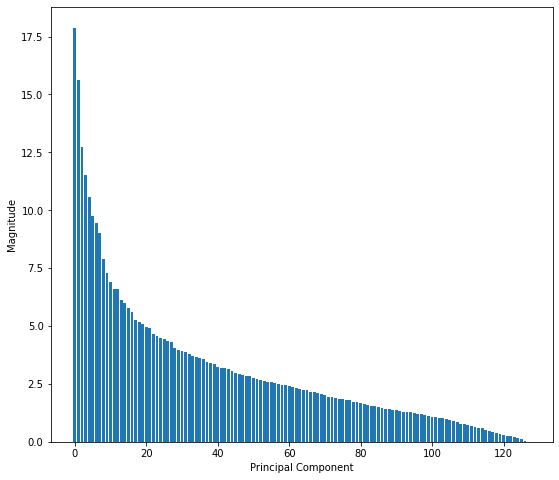

In [77]:
plt.bar(range(mags.shape[0]), mags);
plt.xlabel('Principal Component');
plt.ylabel('Magnitude');

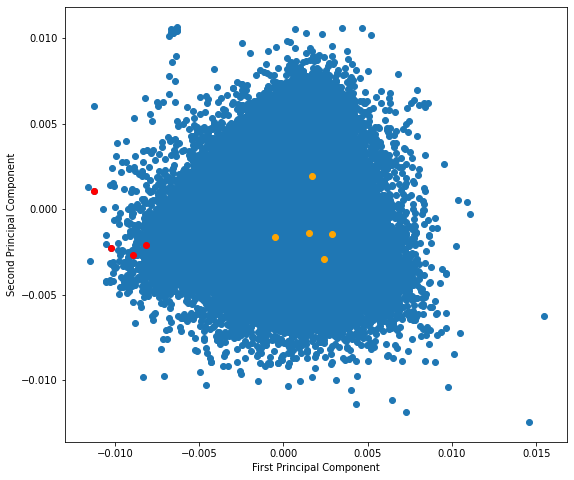

In [78]:
plt.scatter(pcomps[:, 0], pcomps[:, 1]);
plt.xlabel('First Principal Component');
plt.ylabel('Second Principal Component');

words = ('elliott', 'fred', 'frank', 'john')
idxs = [idx2word.index(word) for word in words]
plt.scatter(pcomps[idxs, 0], pcomps[idxs, 1], color='red');


words = ('omega', 'mu', 'alpha', 'beta', 'gamma')
idxs = [idx2word.index(word) for word in words]
plt.scatter(pcomps[idxs, 0], pcomps[idxs, 1], color='orange');

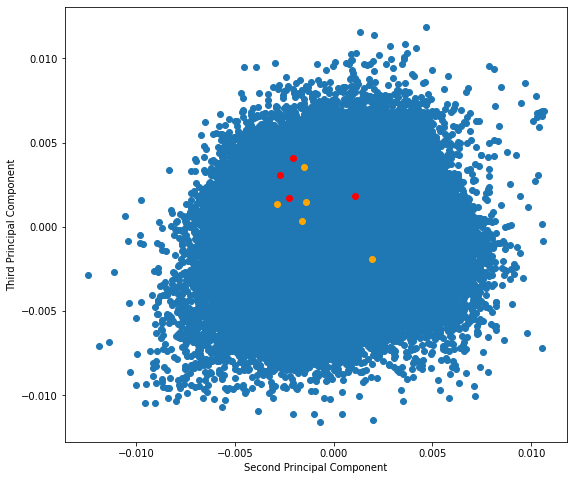

In [79]:
plt.scatter(pcomps[:, 1], pcomps[:, 2]);
plt.xlabel('Second Principal Component');
plt.ylabel('Third Principal Component');

words = ('elliott', 'fred', 'frank', 'john')
idxs = [idx2word.index(word) for word in words]
plt.scatter(pcomps[idxs, 1], pcomps[idxs, 2], color='red');


words = ('omega', 'mu', 'alpha', 'beta', 'gamma')
idxs = [idx2word.index(word) for word in words]
plt.scatter(pcomps[idxs, 1], pcomps[idxs, 2], color='orange');

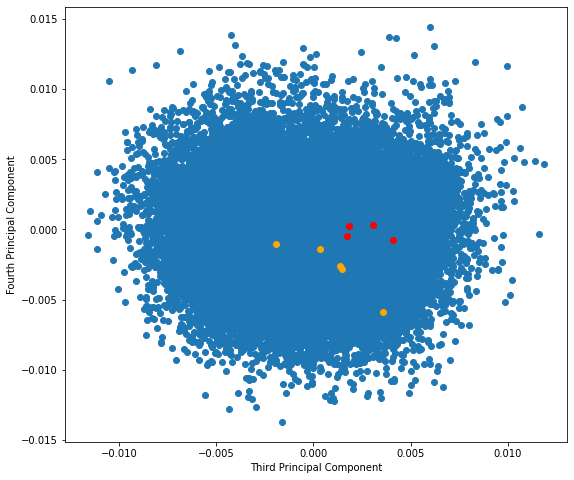

In [80]:
plt.scatter(pcomps[:, 2], pcomps[:, 3]);
plt.xlabel('Third Principal Component');
plt.ylabel('Fourth Principal Component');

words = ('elliott', 'fred', 'frank', 'john')
idxs = [idx2word.index(word) for word in words]
plt.scatter(pcomps[idxs, 2], pcomps[idxs, 3], color='red');


words = ('omega', 'mu', 'alpha', 'beta', 'gamma')
idxs = [idx2word.index(word) for word in words]
plt.scatter(pcomps[idxs, 2], pcomps[idxs, 3], color='orange');